##  Speed and Performance of GB libraries

* [xgboost](https://anaconda.org/conda-forge/xgboost)
* [lightgbm](https://anaconda.org/conda-forge/lightgbm)
* [catboost](https://tech.yandex.com/catboost/doc/dg/concepts/python-installation-docpage/)

We will be comparing the **training time** of the **GBDT**, the
Gradient Boosted Decision Trees, as implemeted by different popular ML libraries.
The dataset is the [UCI Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).


The plan is as follows:
1. Take the **default** parameter settings, measure the training time, and plot
the ROC curves;
2. Use grid search with the $3$-fold cross valiadation to choose the best model.
Then measure the training time as a function of (separately) **tree depth** and **the
number of estimators in the ensemble**, finally **plot the ROC** curves of the best
models.


## Imports and Data

In [5]:
!pip install catboost

     |████████████████████████████████| 64.7MB 58kB/s 


In [0]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)
X.shape

(569, 30)

## Let's find best parameters for every GB package

### CatBoost

In [0]:
def cb():
  cb_params = {
      'learning_rate': [0.01, 0.05, 0.1],
      'depth': [3, 6, 9],
      'l2_leaf_reg': [1, 3, 6],
      'n_estimators': [20]
  }
  grid_search = GridSearchCV(CatBoostClassifier(logging_level = 'Silent'), cb_params,
                              scoring='roc_auc', cv = 3, n_jobs=-1)

  grid_search.fit(X_train, y_train)
  cb_model = grid_search.best_estimator_

  cb_model.fit(X_train, y_train)
  cb_preds = cb_model.predict_proba(X_test)[:, 1]
  return cb_model, cb_preds

In [6]:
cb_model , cb_preds = cb()
print('CatBoost best params are:')
cb_model.get_params()

CatBoost best params are:


{'depth': 9,
 'l2_leaf_reg': 1,
 'learning_rate': 0.01,
 'logging_level': 'Silent',
 'n_estimators': 20}

### XGBoost

In [0]:
def xgb():
  xb_params = {
      'learning_rate': [0.01, 0.05, 0.1],
      'max_depth': [10, 30, 50],
      'min_child_weight': [1, 3, 6],
      'n_estimators': [20]
  }
  grid_search = GridSearchCV(XGBClassifier(), xb_params, 
                            scoring='roc_auc', cv = 3, n_jobs=-1)

  grid_search.fit(X_train, y_train)
  xb_model = grid_search.best_estimator_
  xb_model.fit(X_train, y_train)
  xb_preds = xb_model.predict_proba(X_test)[:, 1]
  return xb_model, xb_preds

In [9]:
xb_model, xb_preds = xgb()
print('XGBoost best params are:')
xb_model.get_params()

XGBoost best params are:


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 3,
 'missing': None,
 'n_estimators': 20,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

### LightGBM

In [0]:
def lgbm():
  lb_params = {
      'learning_rate': [0.01, 0.05, 0.1],
      'max_depth': [10, 30, 50],
      'num_leaves': [300, 900, 1200],
      'n_estimators': [20]
  }
  grid_search = GridSearchCV(LGBMClassifier(), lb_params, 
                            scoring='roc_auc', cv = 3, n_jobs=-1)

  grid_search.fit(X_train, y_train)
  lb_model = grid_search.best_estimator_
  lb_model.fit(X_train, y_train)
  lb_preds = lb_model.predict_proba(X_test)[:, 1]
  return lb_model, lb_preds

In [12]:
lb_model, lb_preds = lgbm()
print('LIghtGBM best params are:')
lb_model.get_params()

LIghtGBM best params are:


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 20,
 'n_jobs': -1,
 'num_leaves': 300,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Plotting ROC-AUCs

In [0]:
def auc_params(preds):
  fpr, tpr, _ = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)
  return fpr, tpr, roc_auc
cb_auc = auc_params(cb_preds)
xb_auc = auc_params(xb_preds)
lb_auc = auc_params(lb_preds)

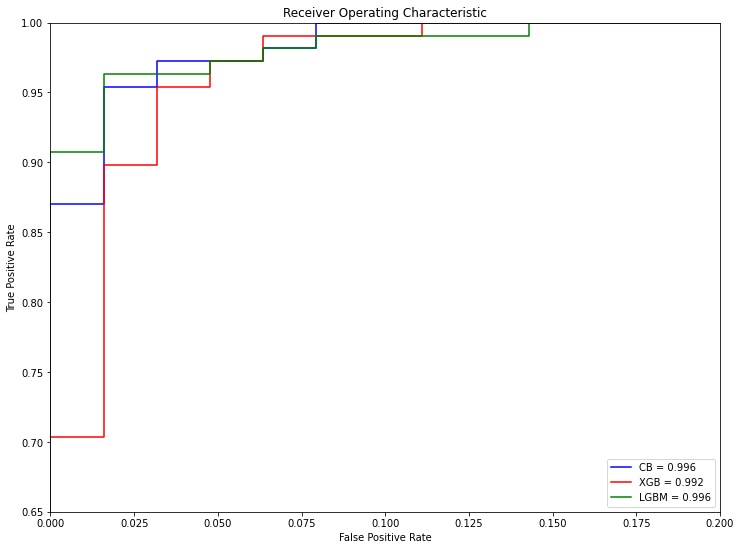

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))
plt.title('Receiver Operating Characteristic')
plt.plot(cb_auc[0], cb_auc[1], 'b', label = 'CB = %0.3f' % cb_auc[2])
plt.plot(xb_auc[0], xb_auc[1], 'r', label = 'XGB = %0.3f' % xb_auc[2])
plt.plot(lb_auc[0], lb_auc[1], 'g', label = 'LGBM = %0.3f' % lb_auc[2])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 0.2])
plt.ylim([0.65, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Time of execution

In [5]:
%%timeit
cb()

1 loop, best of 3: 36.8 s per loop


In [8]:
%%timeit
xgb()

1 loop, best of 3: 1.52 s per loop


In [11]:
%%timeit
lgbm()

1 loop, best of 3: 2.29 s per loop


## Conclusion

On this data, every model has shown an outstanding quality.

> **LGBM** and **Catboost** have slightly better AUC than **XGB**

> But **Catboost** is **~18x** slower than other packages 

Therefore, **LGBM** is the best choice in such scenario